## Automated Tree Cover Loss QC

#### Supported `gfw-data-api` contextual layers:
    - birdlife_key_biodiversity_areas
    - birdlife_alliance_for_zero_extinction_sites
    - gfw_mining_concessions
    - gfw_oil_palm
    - gfw_wood_fiber
    - gmw_global_mangrove_extent_2016
    - idn_forest_moratorium
    - landmark_icls
    - rspo_oil_palm
    - wdpa_protected_areas
    - wwf_tiger_conservation_landscapes

In [3]:
import os
import math
import numpy as np
import rasterio as rio
import rasterio.plot
import fiona
import pandas as pd
import geopandas as gpd
from utils import parse_bounds, concatenate_windows, get_s3_asset_uri, overlay_feature_on_arr
from tqdm.notebook import tqdm
from rasterio.windows import from_bounds
from rasterstats import zonal_stats
from matplotlib import pyplot as plt

In [4]:
# data config
shp_path = '../../data/test/polygon.shp'
IN_DIR = os.path.join(DATA_DIR, 'test', 'shp')
OUT_DIR = os.path.join(DATA_DIR, 'output')
SHP_FN = 'POLYGON.shp'
treecover_threshold = 63
contextual_layers = [
    'wdpa_protected_areas'
]
dissolved=False

shp_fp = os.path.join(IN_DIR, SHP_FN)

In [5]:
# create directories
if not os.path.exists(OUT_DIR):
    os.mkdir(OUT_DIR)

if not os.path.exists('tmp'):
    os.mkdir('tmp')

#### Get admin area bounds

Use bounds to read a window containing the admin zone from raster tiles

In [6]:
with fiona.open(shp_fp) as src:
    bounds = src.bounds
bounds

(-61.50146484374999,
 -22.654571520098994,
 -59.732666015625,
 -19.880391767822495)

In [7]:
X_list, Y_list = parse_bounds(bounds)
X_list, Y_list

(['070W', '060W'], ['20S', '10S'])

#### Intersect admin area with contextual layers

In [8]:
def intersect_layers(layers, bounds, shp_fp, dissolved):

    # return dissolved shapefile if there are no contextual layers
    if len(contextual_layers) == 0:
        adm_shp = gpd.read_file(shp_fp)
        if dissolved==True:
            dissolved = gpd.GeoSeries(adm_shp.geometry).unary_union
            dissolved_gs = gpd.GeoSeries(dissolved)
            dissolved_gs.to_file(os.path.join('tmp', f'{os.path.basename(shp_fp[:-4])}_tmp.shp'))
            return dissolved
        else:
            adm_shp.to_file(os.path.join('tmp', f'{os.path.basename(shp_fp[:-4])}_tmp.shp'))
            return adm_shp

    # parse for s3 paths
    s3_paths = [get_s3_asset_uri(layer) for layer in layers]

    # read contextual layers within bounds of admin area
    contextual_gdfs = []
    for s3_path in s3_paths:
        if s3_path[-4:] == '.zip':
            filename=f'zip+{s3_path}'
        else:
            filename=s3_path
        gdf = gpd.read_file(
            filename=filename,
            bbox=bounds,
        )
        if len(gdf) > 0:
            contextual_gdfs.append(gdf)
        else:
            continue

    if len(contextual_gdfs) == 0:
        raise NoIntersectException('Shapefile does not intersect with contextual layers')

    # intersect all layers
    intersected_gdf = gpd.read_file(shp_fp)
    for contextual_gdf in contextual_gdfs:
        try:
            intersected_gdf = gpd.overlay(intersected_gdf, contextual_gdf, how='intersection')
        except:
            continue

    # dissolve and save to tmp
    if dissolved==True:
        dissolved = gpd.GeoSeries(intersected_gdf.geometry).unary_union
        dissolved_gs = gpd.GeoSeries(dissolved)
        dissolved_gs.to_file(os.path.join('tmp', f'{os.path.basename(shp_fp[:-4])}_tmp.shp'))
        return dissolved_gs
    else:
        return intersected_gdf

In [9]:
intersection = intersect_layers(contextual_layers, bounds, shp_fp, dissolved)

/opt/miniconda3/envs/test-qc-7/lib/python3.9/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [10]:
intersection

,name,desig,desig_type,iucn_cat,gfw_area__ha,gfw_geostore_id,geometry
0,Gran Chaco,Reservas de la Biosfera - Publico,National,Not Reported,4.578204e+06,377cbc60-a913-500e-a7a2-360d211717a6,"MULTIPOLYGON (((-60.53912 -20.65527, -60.77824..."
1,Gran Chaco,Reservas de la Biosfera - Publico,National,Not Reported,4.578204e+06,377cbc60-a913-500e-a7a2-360d211717a6,"POLYGON ((-60.47974 -19.88039, -59.73267 -19.8..."
2,Gran Chaco,UNESCO-MAB Biosphere Reserve,International,Not Applicable,4.578204e+06,377cbc60-a913-500e-a7a2-360d211717a6,"MULTIPOLYGON (((-60.53912 -20.65527, -60.77824..."
3,Gran Chaco,UNESCO-MAB Biosphere Reserve,International,Not Applicable,4.578204e+06,377cbc60-a913-500e-a7a2-360d211717a6,"POLYGON ((-60.47974 -19.88039, -59.73267 -19.8..."
4,Defensores del Chaco,Parque Nacional - Publico,National,II,7.197901e+05,a105a320-5998-c119-c8b2-ab174cfbb25c,"POLYGON ((-60.47974 -20.38583, -60.47974 -19.9..."
5,Punie Pasoi,Reserva Natural - Privado,National,IV,3.645173e+03,eb4691ca-255e-1e9e-dfa4-ef21ab3fd522,"POLYGON ((-59.95514 -21.04349, -59.94586 -21.0..."


#### Threshold tree cover density

Generate binary mask array from the tree cover density tile

In [11]:
tcd_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-data-lake/umd_tree_cover_density_2000/v1.6/raster/epsg-4326/10/40000/percent/geotiff/{Y}_{X}.tif') as src:
            window = from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
            )
            tcd_arrs.append(src.read(1, window=window))
            win_affine = src.window_transform(window)
            
            print(f'Extracted window for {Y}, {X}')

Extracted window for 20S, 070W
Extracted window for 20S, 060W
Extracted window for 10S, 070W
Extracted window for 10S, 060W


In [12]:
tcd_arr = concatenate_windows(tcd_arrs, X_list, Y_list)

In [13]:
# reclassify using binary threshold
tcd_arr_mask = tcd_arr.copy()
tcd_arr_mask[np.where( tcd_arr <= treecover_threshold )] = 0
tcd_arr_mask[np.where( tcd_arr > treecover_threshold )] = 1

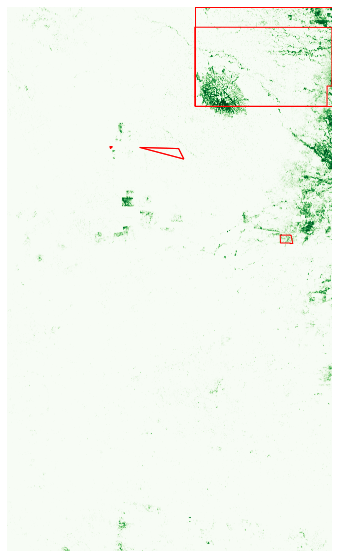

In [14]:
overlay_feature_on_arr(intersection, tcd_arr_mask, win_affine, 'Greens')

#### Set area array

Read area array and mask by tree cover density threshold

In [15]:
area_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-files/2018_update/area/{Y}_{X}.tif') as src:
            area_arr = src.read(1, window=from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
            ))
        area_arrs.append(area_arr)
        
        print(f'Extracted window for {Y}, {X}')

Extracted window for 20S, 070W
Extracted window for 20S, 060W
Extracted window for 10S, 070W
Extracted window for 10S, 060W


In [16]:
area_arr = concatenate_windows(area_arrs, X_list, Y_list)

In [17]:
# mask by treecover threshold array
area_mask = np.multiply(tcd_arr_mask, area_arr)

#### Mask tree cover loss

Read tree cover loss from window and mask using tree cover density threshold

In [18]:
# read as np array from bounds
tcl_arrs = []
for Y in Y_list:
    for X in X_list:
        with rio.open(f's3://gfw-data-lake/umd_tree_cover_loss/v1.7/raster/epsg-4326/10/40000/year/geotiff/{Y}_{X}.tif') as src:
            tcl_arr = src.read(1, window=from_bounds(
                bounds[0],
                bounds[1],
                bounds[2],
                bounds[3],
                src.transform
        ))
        
        tcl_arrs.append(tcl_arr)
        print(f'Extracted window for tree cover loss tile: {Y}, {X}')

Extracted window for tree cover loss tile: 20S, 070W
Extracted window for tree cover loss tile: 20S, 060W
Extracted window for tree cover loss tile: 10S, 070W
Extracted window for tree cover loss tile: 10S, 060W


In [19]:
tcl_arr = concatenate_windows(tcl_arrs, X_list, Y_list)

In [20]:
# mask tree cover loss by treecover threshold
tcl_masked = np.multiply(tcd_arr_mask, tcl_arr)

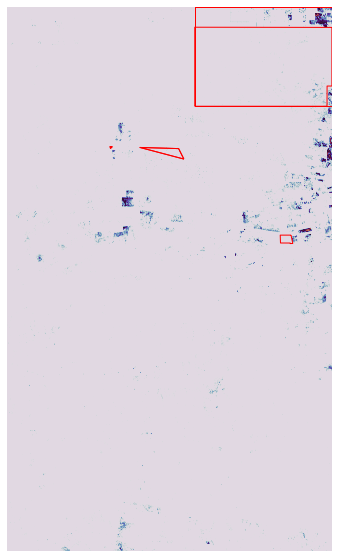

In [21]:
overlay_feature_on_arr(intersection, tcl_masked, win_affine, 'twilight')

#### Compute zonal statistics for admin boundary

In [22]:
loss_by_year_ha = {}

for year in tqdm(range(1,20)):
    
    # copy thresholded tree cover loss array
    tcl_arr_year = tcl_masked.copy()
    
    # mask by current year
    tcl_arr_year[np.where( tcl_masked != year )] = 0
    tcl_arr_year[np.where( tcl_masked == year )] = 1
    
    # convert to ha using area mask
    tcl_arr_year_area = np.multiply(area_mask, tcl_arr_year) / 10000
    
    # compute zonal stats for admin area
    zstats = zonal_stats(
        os.path.join('tmp', f'{os.path.basename(shp_fp[:-4])}_tmp.shp'),
        tcl_arr_year_area,
        stats='sum',
        affine=win_affine,
        all_touched=False,
        nodata=-999
    )
    
    # log
    annual_loss_df = pd.DataFrame(zstats)
    annual_loss_df['year']=year+2000
    annual_loss = annual_loss_df['sum'].sum()
    print(f'TCL in {year + 2000}: {int(annual_loss)} ha')
    loss_by_year_ha[year + 2000] = annual_loss

  0%|          | 0/19 [00:00<?, ?it/s]

TCL in 2001: 119 ha
TCL in 2002: 93 ha
TCL in 2003: 77 ha
TCL in 2004: 193 ha
TCL in 2005: 234 ha
TCL in 2006: 352 ha
TCL in 2007: 834 ha
TCL in 2008: 923 ha
TCL in 2009: 581 ha
TCL in 2010: 1195 ha
TCL in 2011: 2705 ha
TCL in 2012: 1876 ha
TCL in 2013: 129 ha
TCL in 2014: 467 ha
TCL in 2015: 275 ha
TCL in 2016: 258 ha
TCL in 2017: 221 ha
TCL in 2018: 1044 ha
TCL in 2019: 561 ha


#### Save as CSV

In [23]:
loss_df = pd.DataFrame.from_dict(loss_by_year_ha, orient='index')
loss_df = loss_df.rename(columns={0:'area_ha'})
loss_df['threshold'] = f'{treecover_threshold}%'
for i in range(len(contextual_layers)):
    loss_df[f'intersection_{i+1}'] = contextual_layers[i]

In [24]:
loss_df.to_csv(os.path.join(
    OUT_DIR, 
    f'{SHP_FN[:-4]}__tree_cover_loss_ha__tcd{treecover_threshold}.csv')
)

In [25]:
loss_df

,area_ha,threshold,intersection_1
2001,119.927839,63%,wdpa_protected_areas
2002,93.796294,63%,wdpa_protected_areas
2003,77.873562,63%,wdpa_protected_areas
2004,193.096596,63%,wdpa_protected_areas
2005,234.135635,63%,wdpa_protected_areas
2006,352.457806,63%,wdpa_protected_areas
2007,834.264128,63%,wdpa_protected_areas
2008,923.813744,63%,wdpa_protected_areas
2009,581.341229,63%,wdpa_protected_areas
2010,1195.012944,63%,wdpa_protected_areas
